In [24]:
# import os
# import json
# import re
# import pandas as pd

# RESULTS_ROOT = "/mnt/hdd/ttoxopeus/basic_UNet/results"
# MODEL_NAME = "UNet_ACDC"  # change if needed


# def _read_json(path: str) -> dict | None:
#     if not os.path.isfile(path):
#         return None
#     with open(path, "r") as f:
#         return json.load(f)


# def _extract_threshold(run_name: str) -> float | None:
#     """
#     Extract threshold from names like: corr_t92_...
#     Returns 0.92 for 't92'. If not found (e.g. baseline), returns None.
#     """
#     m = re.search(r"_t(\d+)", run_name)
#     if not m:
#         return 1
#     return float(m.group(1)) / 100.0


# def _flatten_eval_metrics(d: dict, run_name: str, run_path: str) -> dict:
#     """
#     Turns your eval_metrics.json dict into a single flat row.
#     Expands per_class into columns.
#     """
#     row = {
#         "run_name": run_name,
#         "run_path": run_path,
#         "threshold": _extract_threshold(run_name),  # <-- added
#         "phase": d.get("phase"),
#         "params_m": d.get("params_m"),
#         "flops_g": d.get("flops_g"),
#         "inference_ms": d.get("inference_ms"),
#         "vram_peak_mb": d.get("vram_peak_mb"),
#         "mean_dice_fg": d.get("mean_dice_fg"),
#         "std_dice_fg": d.get("std_dice_fg"),
#         "mean_iou_fg": d.get("mean_iou_fg"),
#         "std_iou_fg": d.get("std_iou_fg"),
#     }

#     per_class = d.get("per_class", {}) or {}
#     for cls_name, cls_metrics in per_class.items():
#         cls_slug = cls_name.lower().replace(" ", "_")
#         row[f"{cls_slug}_dice_mean"] = cls_metrics.get("dice_mean")
#         row[f"{cls_slug}_dice_std"] = cls_metrics.get("dice_std")
#         row[f"{cls_slug}_iou_mean"] = cls_metrics.get("iou_mean")
#         row[f"{cls_slug}_iou_std"] = cls_metrics.get("iou_std")

#     return row


# def load_experiment_eval_df(
#     exp_name: str,
#     required_substring: str | None = None,
#     pruned_eval_relpath: str = os.path.join("retrained_pruned_evaluation", "run_summary.json"),
#     baseline_eval_relpath: str = os.path.join("baseline", "evaluation", "run_summary.json"),
#     model_name: str = MODEL_NAME,
#     results_root: str = RESULTS_ROOT,
# ) -> pd.DataFrame:
#     """
#     Returns a DataFrame for one experiment:
#     - Row 0 = baseline evaluation
#     - Following rows = each pruned run under /pruned/*

#     Filter:
#       required_substring: only include pruned folders whose name contains this substring
#     """
#     exp_root = os.path.join(results_root, model_name, exp_name)

#     # -------- baseline first --------
#     baseline_path = os.path.join(exp_root, baseline_eval_relpath)
#     baseline_json = _read_json(baseline_path)
#     if baseline_json is None:
#         raise FileNotFoundError(f"Baseline eval_metrics.json not found at: {baseline_path}")

#     rows = [
#         _flatten_eval_metrics(
#             baseline_json,
#             run_name="baseline",
#             run_path=os.path.dirname(baseline_path),
#         )
#     ]

#     # -------- pruned runs --------
#     pruned_dir = os.path.join(exp_root, "pruned")
#     if not os.path.isdir(pruned_dir):
#         df = pd.DataFrame(rows)
#         df["model_size_pct"] = 100.0
#         return df

#     for run_name in sorted(os.listdir(pruned_dir)):
#         run_path = os.path.join(pruned_dir, run_name)
#         if not os.path.isdir(run_path):
#             continue

#         # Filter only PRUNED runs (baseline is always included above)
#         if required_substring and required_substring not in run_name:
#             continue

#         metrics_path = os.path.join(run_path, pruned_eval_relpath)
#         d = _read_json(metrics_path)
#         if d is None:
#             continue

#         rows.append(_flatten_eval_metrics(d, run_name=run_name, run_path=run_path))

#     df = pd.DataFrame(rows)
#     if df.empty:
#         return df

#     # --------------------------
#     # Add model size (% of baseline params)
#     # --------------------------
#     baseline_params = df.loc[df["run_name"] == "baseline", "params_m"].iloc[0]
#     df["model_size_pct"] = 100.0 * df["params_m"] / baseline_params

#     # Nice ordering: baseline first, then pruned sorted by params (descending) or dice (descending)
#     is_baseline = df["run_name"].eq("baseline")
#     df_pruned = df.loc[~is_baseline].sort_values(
#         ["params_m", "mean_dice_fg"], ascending=[False, False]
#     )
#     df = pd.concat([df.loc[is_baseline], df_pruned], ignore_index=True)

#     # Put key columns up front
#     front = [
#         "run_name",
#         "threshold",          # <-- added
#         "phase",
#         "model_size_pct",
#         "params_m",
#         "flops_g",
#         "inference_ms",
#         "vram_peak_mb",
#         "mean_dice_fg",
#         "std_dice_fg",
#         "mean_iou_fg",
#         "std_iou_fg",
#         "run_path",
#     ]
#     df = df[front + [c for c in df.columns if c not in front]]

#     return df


# # --------------------------
# # Example usage
# # --------------------------
# EXP_NAME = "exp63_uniform"

# df = load_experiment_eval_df(EXP_NAME, required_substring="l1_norm")
# #df = df.sort_values("threshold", ascending=False)

# # df = df[:-4]

# pd.set_option("display.max_rows", None)
# display(df)


import os
import json
import re
import pandas as pd

RESULTS_ROOT = "/mnt/hdd/ttoxopeus/basic_UNet/results"
MODEL_NAME = "UNet_ACDC"  # change if needed


def _read_json(path: str) -> dict | None:
    if not os.path.isfile(path):
        return None
    with open(path, "r") as f:
        return json.load(f)


def _extract_threshold(run_name: str) -> float:
    """
    Extract threshold from names like: corr_t92_...
    Returns 0.92 for 't92'. If not found, returns 1.0.
    """
    m = re.search(r"_t(\d+)", run_name)
    if not m:
        return 1.0
    return float(m.group(1)) / 100.0



def _flatten_run_summary(d: dict, run_name: str, run_path: str) -> dict:
    """
    Turns your run_summary.json (new schema) into a single flat row.
    Expands eval.per_class into columns.
    """
    exp = d.get("experiment", {}) or {}
    ev = d.get("eval", {}) or {}
    fg = ev.get("foreground", {}) or {}
    prof = d.get("profile", {}) or {}

    row = {
        "run_name": run_name,
        "run_path": run_path,
        "threshold": _extract_threshold(run_name),
        "stage": d.get("stage"),
        "phase": ev.get("phase"),

        # profile
        "params_m": prof.get("params_m"),
        "flops_g": prof.get("flops_g"),
        "inference_ms": prof.get("inference_ms"),

        # eval
        "vram_peak_mb": ev.get("vram_peak_mb"),
        "mean_dice_fg": fg.get("dice_mean"),
        "std_dice_fg": fg.get("dice_std"),
        "mean_iou_fg": fg.get("iou_mean"),
        "std_iou_fg": fg.get("iou_std"),

        # optional metadata
        "seed": exp.get("seed"),
        "device": exp.get("device"),
        "checkpoint": ev.get("checkpoint"),
    }

    per_class = ev.get("per_class", {}) or {}
    for cls_name, cls_metrics in per_class.items():
        cls_slug = cls_name.lower().replace(" ", "_")
        row[f"{cls_slug}_dice_mean"] = cls_metrics.get("dice_mean")
        row[f"{cls_slug}_dice_std"] = cls_metrics.get("dice_std")
        row[f"{cls_slug}_iou_mean"] = cls_metrics.get("iou_mean")
        row[f"{cls_slug}_iou_std"] = cls_metrics.get("iou_std")

    return row


def load_experiment_eval_df(
    exp_name: str,
    required_substring: str | None = None,
    exclude_substrings: str | list[str] | None = None,
    pruned_eval_relpath: str = os.path.join("pruned_evaluation", "run_summary.json"),
    baseline_eval_relpath: str = os.path.join("baseline", "evaluation", "run_summary.json"),
    model_name: str = MODEL_NAME,
    results_root: str = RESULTS_ROOT,
) -> pd.DataFrame:
    """
    Returns a DataFrame for one experiment:
    - Row 0 = baseline evaluation
    - Following rows = each pruned run under /pruned/*
    Reads new-schema run_summary.json.

    Filters:
      required_substring: only include pruned folders whose name contains this substring
      exclude_substrings: comma-separated string or list of substrings to skip
    """
    exp_root = os.path.join(results_root, model_name, exp_name)

    # normalize excludes
    exclude_list: list[str] = []
    if isinstance(exclude_substrings, str):
        exclude_list = [s.strip() for s in exclude_substrings.split(",") if s.strip()]
    elif exclude_substrings:
        exclude_list = list(exclude_substrings)

    # -------- baseline first --------
    baseline_path = os.path.join(exp_root, baseline_eval_relpath)
    baseline_json = _read_json(baseline_path)
    if baseline_json is None:
        raise FileNotFoundError(f"Baseline run_summary.json not found at: {baseline_path}")

    rows = [
        _flatten_run_summary(
            baseline_json,
            run_name="baseline",
            run_path=os.path.dirname(baseline_path),
        )
    ]

    # -------- pruned runs --------
    pruned_dir = os.path.join(exp_root, "pruned")
    if not os.path.isdir(pruned_dir):
        df = pd.DataFrame(rows)
        df["model_size_pct"] = 100.0
        return df

    for run_name in sorted(os.listdir(pruned_dir)):
        run_path = os.path.join(pruned_dir, run_name)
        if not os.path.isdir(run_path):
            continue

        if required_substring and required_substring not in run_name:
            continue
        if exclude_list and any(excl in run_name for excl in exclude_list):
            continue

        metrics_path = os.path.join(run_path, pruned_eval_relpath)
        d = _read_json(metrics_path)
        if d is None:
            continue

        rows.append(_flatten_run_summary(d, run_name=run_name, run_path=run_path))

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # --------------------------
    # Add model size (% of baseline params)
    # --------------------------
    baseline_params = df.loc[df["run_name"] == "baseline", "params_m"].iloc[0]
    df["model_size_pct"] = 100.0 * df["params_m"] / baseline_params

    # ordering: baseline first, then pruned
    is_baseline = df["run_name"].eq("baseline")
    df_pruned = df.loc[~is_baseline].sort_values(
        ["params_m", "mean_dice_fg"], ascending=[False, False]
    )
    df = pd.concat([df.loc[is_baseline], df_pruned], ignore_index=True)

    front = [
        "run_name",
        "threshold",
        "phase",
        "model_size_pct",
        "params_m",
        "flops_g",
        "inference_ms",
        "vram_peak_mb",
        "mean_dice_fg",
        "std_dice_fg",
        "mean_iou_fg",
        "std_iou_fg",
        "seed",
        "device",
        "checkpoint",
        "run_path",
    ]
    df = df[front + [c for c in df.columns if c not in front]]

    return df


# --------------------------
# Example usage
# --------------------------
EXP_NAME = "exp78_test"

df = load_experiment_eval_df(
    EXP_NAME,
    required_substring=None,
    exclude_substrings=None,  # e.g. "seed1,seed2"
)

# indices_to_drop = []

# df = df.drop(index=indices_to_drop)

pd.set_option("display.max_rows", None)
display(df)



,run_name,threshold,phase,model_size_pct,params_m,flops_g,inference_ms,vram_peak_mb,mean_dice_fg,std_dice_fg,...,rv_iou_mean,rv_iou_std,myocardium_dice_mean,myocardium_dice_std,myocardium_iou_mean,myocardium_iou_std,lv_dice_mean,lv_dice_std,lv_iou_mean,lv_iou_std
0,baseline,1.0,baseline_evaluation,100.000000,43.886340,54.440493,2.496977,450.885254,0.855368,0.170982,...,0.773098,0.286082,0.837730,0.190690,0.751938,0.194311,0.901279,0.200630,0.857320,0.205445
1,l1_norm_0_0_0_0_0_0_0_0_0_0_0,1.0,pruned_evaluation,100.000000,43.886340,54.440493,2.522221,282.145996,0.855052,0.171169,...,0.775995,0.285343,0.837472,0.194651,0.752712,0.197231,0.898419,0.203218,0.853273,0.207121
2,l1_norm_5_5_5_5_5_5_5_5_5_5_5,1.0,pruned_evaluation,90.458345,39.698857,49.399789,3.620925,277.970215,0.836809,0.180802,...,0.753782,0.295754,0.815541,0.209078,0.725419,0.213534,0.883683,0.218343,0.834240,0.220979
3,l1_norm_10_10_10_10_10_10_10_10_10_10_10,1.0,pruned_evaluation,81.127036,35.603687,44.456122,3.481302,254.772949,0.768331,0.217244,...,0.666383,0.334887,0.749954,0.243667,0.647267,0.248198,0.821504,0.268912,0.757703,0.269437
4,l1_norm_15_15_15_15_15_15_15_15_15_15_15,1.0,pruned_evaluation,72.478569,31.808191,39.651868,3.254209,235.450684,0.514841,0.286453,...,0.427201,0.380904,0.526323,0.316122,0.420516,0.301187,0.523925,0.364997,0.438442,0.342896
5,l1_norm_20_20_20_20_20_20_20_20_20_20_20,1.0,pruned_evaluation,64.152584,28.154221,35.236682,3.054485,201.260254,0.192702,0.273947,...,0.209008,0.384170,0.234868,0.311577,0.183148,0.289424,0.120330,0.301426,0.110954,0.294410
6,l1_norm_25_25_25_25_25_25_25_25_25_25_25,1.0,pruned_evaluation,56.257770,24.689476,30.657085,1.977873,182.566406,0.118612,0.275868,...,0.181227,0.385206,0.082601,0.272471,0.081786,0.272453,0.092007,0.289036,0.092007,0.289036
7,l1_norm_30_30_30_30_30_30_30_30_30_30_30,1.0,pruned_evaluation,49.160830,21.574889,26.905023,2.678518,176.664062,0.118030,0.276076,...,0.181227,0.385206,0.080855,0.272612,0.080855,0.272612,0.092007,0.289036,0.092007,0.289036
8,l1_norm_35_35_35_35_35_35_35_35_35_35_35,1.0,pruned_evaluation,42.348537,18.585223,23.290910,2.490993,160.221680,0.118030,0.276076,...,0.181227,0.385206,0.080855,0.272612,0.080855,0.272612,0.092007,0.289036,0.092007,0.289036
9,l1_norm_40_40_40_40_40_40_40_40_40_40_40,1.0,pruned_evaluation,36.167644,15.872655,19.851583,2.050924,122.467285,0.118030,0.276076,...,0.181227,0.385206,0.080855,0.272612,0.080855,0.272612,0.092007,0.289036,0.092007,0.289036


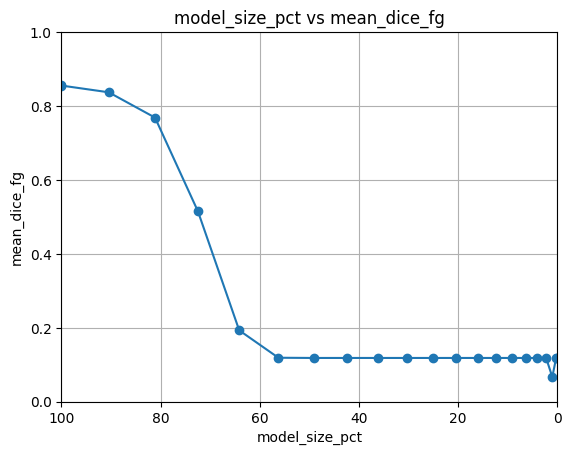

In [25]:
import matplotlib.pyplot as plt

def plot_df_xy(df, x_col, y_col):
    plt.figure()
    plt.plot(df[x_col], df[y_col], marker='o')
    plt.title(f'{x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)

    plt.xlim(max(df[x_col]), 0)   
    plt.ylim(0, 1)     

    plt.grid(True)
    plt.show()


plot_df_xy(df, "model_size_pct", "mean_dice_fg")
#plot_df_xy(df, "threshold", "mean_dice_fg")

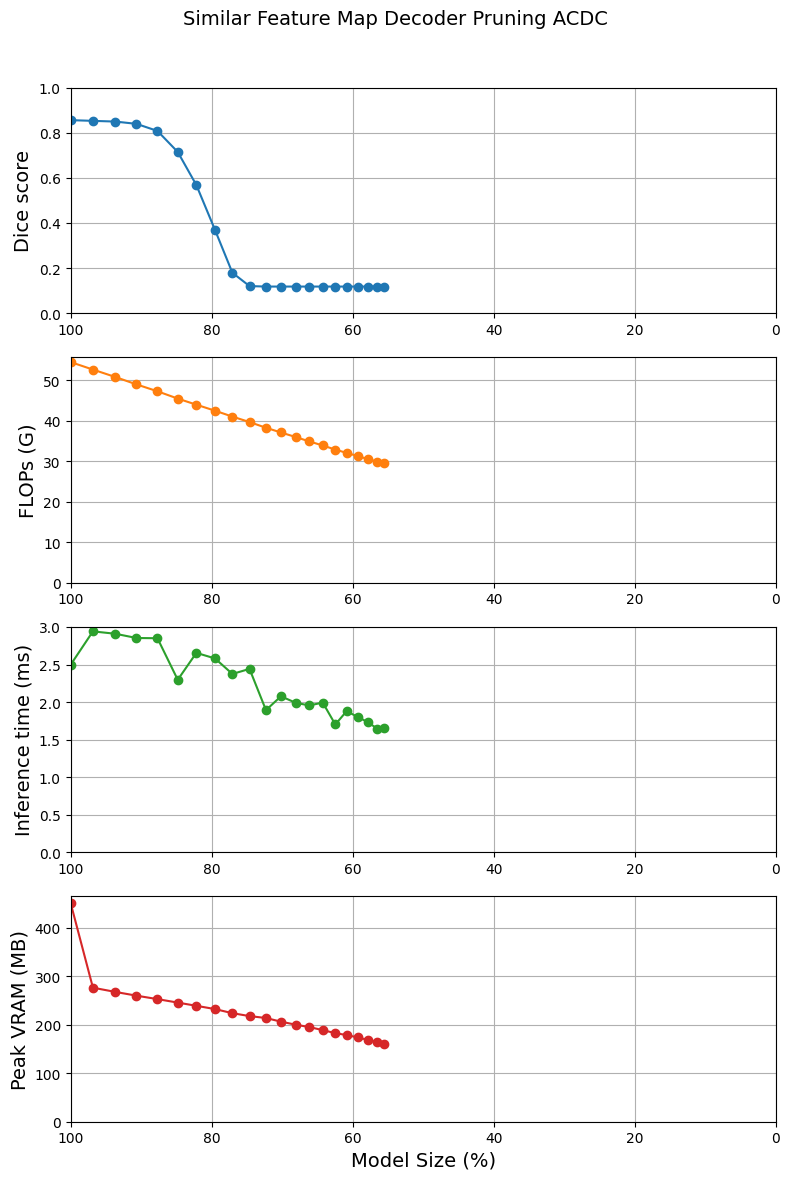

In [18]:
def plot_pruning_summary(df, x_col, y_col):

    plt.figure(figsize=(8, 12))
    fs = 14

    # 1. Dice
    plt.subplot(4, 1, 1)
    plt.plot(df[x_col], df[y_col[0]], marker="o", color="tab:blue")
    plt.ylabel("Dice score", fontsize=fs)
    plt.ylim(0, 1)
    plt.xlim(max(df[x_col]), 0) 
    plt.grid(True)

    # 2. FLOPs
    plt.subplot(4, 1, 2)
    plt.plot(df[x_col], df[y_col[1]], marker="o", color="tab:orange")
    plt.ylabel("FLOPs (G)", fontsize=fs)
    plt.xlim(max(df[x_col]), 0) 
    plt.ylim(bottom=0)
    plt.grid(True)

    # 3. Inference time
    plt.subplot(4, 1, 3)
    plt.plot(df[x_col], df[y_col[2]], marker="o", color="tab:green")
    plt.ylabel("Inference time (ms)", fontsize=fs)
    plt.xlim(max(df[x_col]), 0) 
    plt.ylim(bottom=0)
    plt.grid(True)

    # 4. VRAM
    plt.subplot(4, 1, 4)
    plt.plot(df[x_col], df[y_col[3]], marker="o", color="tab:red")
    plt.xlabel("Model Size (%)", fontsize=fs)
    plt.ylabel("Peak VRAM (MB)", fontsize=fs)
    plt.xlim(max(df[x_col]), 0) 
    plt.ylim(bottom=0)
    plt.grid(True)

    plt.suptitle(f'Similar Feature Map Decoder Pruning ACDC', fontsize=fs)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



plot_pruning_summary(df, "model_size_pct", ["mean_dice_fg", "flops_g", "inference_ms", "vram_peak_mb"])
